##Midterm

In [84]:
import pandas as pd
import numpy as np
import csv as csv
import scipy
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrices
import sklearn.cross_validation as cv
import matplotlib.pyplot as plt 
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, train_test_split

# loading input files, test.csv is the same as train.csv without the Survived column
train_path = "train.csv"
test_path = "test.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [85]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [86]:
# clean the data for genders
train_data['Gender'] = train_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_data['Gender'] = test_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [87]:
# fill data for missing Age values using median of gender/class group in both test/train data
median_ages = np.zeros(3)
for i in range(1,4):
    median_ages[i-1] = train_data[train_data["Pclass"] == i]["Age"].dropna().median()

for i in range(1,4):
    train_data.loc[(train_data["Age"].isnull()) & (train_data["Pclass"] == i), "Age"] = median_ages[i-1]
    test_data.loc[(test_data["Age"].isnull()) & (test_data["Pclass"] == i), "Age"] = median_ages[i-1]

In [88]:
# transform the age variable into a discrete variable, binned in increments of 10
train_data['Age_discrete'] = train_data['Age'].apply(lambda x: int(x - (x % 10)))

In [89]:
# transform the fare variable into a discrete variable, binned in increments of 25
train_data['Fare_discrete'] = train_data['Fare'].apply(lambda x: int(x - (x % 25)))

In [90]:
# drop all string variables
train_data = train_data.drop([ 'Pclass', 'Name', 'Sex', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)

In [91]:
#new train_data with removed variables and missing values filled in for age
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 6 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
SibSp            891 non-null int64
Gender           891 non-null int64
Age_discrete     891 non-null int64
Fare_discrete    891 non-null int64
dtypes: int64(6)
memory usage: 48.7 KB


In [92]:
#repeat for test_data for removing string variable
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Gender         418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


In [93]:
#replace NaN values in fare using the median 
#(missing age values have been replaced in code above) 
if len(test_data.Fare[ test_data.Fare.isnull() ]) > 0:
    median_fares = np.zeros(3)
for fare in range(0,3): # loop 0 to 2
    median_fares[fare] = test_data[ test_data.Pclass == fare+1 ]['Fare'].dropna().median()
for fare in range(0,3): # loop 0 to 2
    test_data.loc[ (test_data.Fare.isnull()) & (test_data.Pclass == fare+1 ), 'Fare'] = median_fares[fare]

In [94]:
# transform the age variable into a discrete variable, binned in increments of 10
test_data['Age_discrete'] = test_data['Age'].apply(lambda x: int(x - (x % 10)))

In [95]:
# transform the fare variable into a discrete variable, binned in increments of 25
test_data['Fare_discrete'] = test_data['Fare'].apply(lambda x: int(x - (x % 25)))

In [96]:
# drop all string variables
test_data = test_data.drop(['Pclass', 'Name', 'Sex', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1)

In [97]:
#new test_data with removed variables and missing values filled for age and fare
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 5 columns):
PassengerId      418 non-null int64
SibSp            418 non-null int64
Gender           418 non-null int64
Age_discrete     418 non-null int64
Fare_discrete    418 non-null int64
dtypes: int64(5)
memory usage: 19.6 KB


In [98]:
train_data_np = train_data.astype(np.int32).values
X= train_data_np[:,:-1]
y=train_data_np[:,-1]

In [99]:
#We split X and y into train and test datasets
(X_train_data, X_test_data, y_train_data, y_test_data) = cv.train_test_split(X, y, test_size=.05)

In [100]:
#We instanciate the classifier
logreg = LogisticRegression()

In [101]:
#Train model and we get predicted values on the test set
logreg.fit(X_train_data, y_train_data)
y_predicted = logreg.predict(X_test_data)

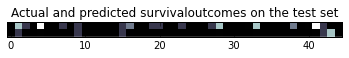

In [102]:
#outcomes
plt.imshow(np.vstack((y_test_data, y_predicted)), 
interpolation='none', cmap='bone')
plt.yticks([]);
plt.title(("Actual and predicted survival" "outcomes on the test set"))

In [103]:
cv.cross_val_score(logreg, X, y)

array([ 0.52842809,  0.6442953 ,  0.65986395])

In [83]:
res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     72.00
Date:                Fri, 11 Sep 2015   Prob (F-statistic):           7.66e-53
Time:                        04:15:35   Log-Likelihood:                -4699.9
No. Observations:                 891   AIC:                             9408.
Df Residuals:                     887   BIC:                             9427.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0041      0.005      0.748      0.455        -0.007     0.015
x2            24.7738      3.307      7.492      0.000        18.284    31.264
x3            -4.3567      3.262     -1.336      0.182       -10.758     2.045
x4             0.5640      0.102      5.507      0.000         0.363     0.765
==============================================================================
Omnibus:                      898.687   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45560.646
Skew:                           4.709   Prob(JB):                         0.00
Kurtosis:                      36.742   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
output = res.predict(y_test_data)
output = np.asanyarray(output).ravel()
output = np.round(output)

ValueError: shapes (1,45) and (4,) not aligned: 45 (dim 1) != 4 (dim 0)

In [ ]:
output_file = open("Logit.csv", "wb")
output_file_object = csv.writer(output_file)
output_file_object.writerow(["PassengerId", "Survived"])
output_file_object.writerows(zip(test_data["PassengerId"], output))
output_file.close()

In [ ]:
# IMPLEMENTING K-FOLD CLASSIFICATION

In [ ]:
# separating predictor columns from response columns
x_train_data = train_data[train_data.columns.values[1:]].as_matrix()
response_train_data= train_data.Survived.as_matrix()

In [ ]:
# use sklearn to create indices on which to split for each fold
tenFold = StratifiedKFold(response_train_data, n_folds=10)
cCorrect = 0
cTotal = 0

In [ ]:
# iterate through each set of indices
for i, (tr,te) in enumerate(tenFold):
    x_tr = x_train_data[tr]
    out_tr = response_train_data[tr]
    x_te = x_train_data[te]
    out_te = response_train_data[te]
# construct new classifier each time
model = RandomForestClassifier()
model.fit(x_tr, out_tr)
out_pred = model.predict(x_te)
correct, total = (out_te == out_pred).sum(), len(out_te)
# increment accuracy values with each iteration
cCorrect += correct
cTotal += total
print '10-fold accuracy: %f' % (cCorrect * 1.0 / cTotal)
print "\n"

In [ ]:
model = RandomForestClassifier()
model.fit(x_train_data, response_train_data)

In [ ]:
# use pandas to iterate through feature combinations and return the best one
fRank = pd.Series(model.feature_importances_, index=train_data.columns.values[1:]).order(ascending=False)
print fRank
print "\n"

In [ ]:
# tuning attributes we are interested in testing
options = {
"n_estimators": [100],
"criterion": ['gini', 'entropy'],
'max_features': [1.0, .50, 'sqrt'],
'max_depth': [3,4,5,6,7,8, None],
'min_samples_split': [1,2],
'min_samples_leaf': [1,2]
    }

In [ ]:
model = RandomForestClassifier()
tuning = GridSearchCV(model, options, cv=12, verbose=0)
tuning.fit(x_train_data, response_train_data)


In [ ]:
print tuning.best_score_
print tuning.best_params_

In [ ]:
# fit the forest using best tuning attributes
forest = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_features='sqrt', \
max_depth=6, min_samples_leaf = 1, min_samples_split = 2)
forest = forest.fit(train_dataValues[0::,1::],train_dataValues[0::,0])

In [ ]:
# predict the test data
predictions = forest.predict(test_dataValues).astype(int)

In [ ]:
output_file = open("RFC.csv", "wb")
output_file_object = csv.writer(output_file)
output_file_object.writerow(["PassengerId", "Survived"])
output_file_object.writerows(zip(test_data["PassengerId"], output))
output_file.close()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
 
# shuffle and split training and test sets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=.25)
forest.fit(X_train_data, y_train_data)

In [ ]:
 # Determine the false positive and true positive rates
fpr, tpr,_ = roc_curve(y_test_data, forest.predict(X_test_data)[0::,0])

In [ ]:
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

In [5]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, _='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'fpr' is not defined